In [17]:
# build by swimchicken
# 23/12/23 data

# TODO 引入資料處理模組 and 深度學習模組

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, add
from tensorflow.keras.utils import plot_model

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
file_path = '/content/drive/MyDrive/深度學習-期末/fer2013.csv'

In [20]:

# TODO 引入資料並預處理

label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names = ['emotion', 'pixels', 'usage']

df = pd.read_csv(file_path, names=names, na_filter=False)
df = df.iloc[1:]

In [21]:
print(df.head())

  emotion                                             pixels     usage
1       0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
2       0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
3       2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
4       4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
5       6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


第一章圖像資料:  [[[ 70.]
  [ 80.]
  [ 82.]
  ...
  [ 52.]
  [ 43.]
  [ 41.]]

 [[ 65.]
  [ 61.]
  [ 58.]
  ...
  [ 56.]
  [ 52.]
  [ 44.]]

 [[ 50.]
  [ 43.]
  [ 54.]
  ...
  [ 49.]
  [ 56.]
  [ 47.]]

 ...

 [[ 91.]
  [ 65.]
  [ 42.]
  ...
  [ 72.]
  [ 56.]
  [ 43.]]

 [[ 77.]
  [ 82.]
  [ 79.]
  ...
  [105.]
  [ 70.]
  [ 46.]]

 [[ 77.]
  [ 72.]
  [ 84.]
  ...
  [106.]
  [109.]
  [ 82.]]]
(35887, 48, 48, 1)
第一章類別資料:  0
(35887,)


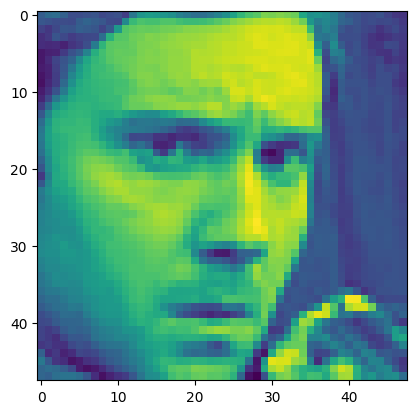

In [22]:

def get_train_data(data):
    train_data = data['pixels'].apply(lambda pixels: np.fromstring(pixels, sep=' ', dtype=np.float32))
    train_data = np.vstack(train_data).reshape(len(df), 48, 48, 1)
    return train_data


x = get_train_data(df)
y = df['emotion'].to_numpy().astype('int')

print("第一章圖像資料: ", x[0])
print(x.shape)
print("第一章類別資料: ", y[0])
print(y.shape)
plt.imshow(x[0].reshape(48, 48))
plt.show()


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# 轉成one-hot編碼

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print(y_train.shape)
print(y_train[0])

(24044, 7)
[0. 0. 0. 0. 1. 0. 0.]


In [24]:
class TimeHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_time_start = None
        self.times = None

    def on_train_begin(self, logs=None):
        if logs is None:
            logs = {}
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.times.append(time.time() - self.epoch_time_start)


time_callback_vgg = TimeHistory()
time_callback_unet = TimeHistory()
time_callback_resid = TimeHistory()


In [25]:
# TODO 創建各模型
# vgg網路

def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2, 2), strides=(2, 2))(layer_in)
    return layer_in


# define model input
visible = Input(shape=(48, 48, 1))
# add vgg module
layer = vgg_block(visible, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 4)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_vgg = Model(inputs=visible, outputs=layer)
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_vgg = model_vgg.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test),
                            callbacks=[time_callback_vgg])

Epoch 1/20
  5/752 [..............................] - ETA: 21s - loss: 8.5243 - accuracy: 0.1937 

752/752 [==============================] - 23s 28ms/step - loss: 1.8610 - accuracy: 0.2490 - val_loss: 1.8120 - val_accuracy: 0.2504
Epoch 2/20
752/752 [==============================] - 17s 23ms/step - loss: 1.7752 - accuracy: 0.2707 - val_loss: 1.6433 - val_accuracy: 0.3578
Epoch 3/20
752/752 [==============================] - 19s 25ms/step - loss: 1.5249 - accuracy: 0.4110 - val_loss: 1.4179 - val_accuracy: 0.4565
Epoch 4/20
752/752 [==============================] - 17s 23ms/step - loss: 1.3375 - accuracy: 0.4855 - val_loss: 1.3420 - val_accuracy: 0.4927
Epoch 5/20
752/752 [==============================] - 18s 24ms/step - loss: 1.2396 - accuracy: 0.5263 - val_loss: 1.2521 - val_accuracy: 0.5256
Epoch 6/20
752/752 [==============================] - 18s 24ms/step - loss: 1.1726 - accuracy: 0.5536 - val_loss: 1.2305 - val_accuracy: 0.5321
Epoch 7/20
752/752 [==============================] - 17s 23ms/step - loss: 1.0999 - accuracy: 0.5841 - val_loss: 1.2345 - val_accuracy: 0.5369
Epo

In [26]:
model_vgg.save('model_vgg.keras')

In [27]:
save_path = '/content/drive/MyDrive'
!mv model_vgg.keras /content/drive/MyDrive/

In [28]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [29]:
# define model input
visible = Input(shape=(48, 48, 1))
# add vgg module
layer = residual_module(visible, 64)
# create model

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_residual = Model(inputs=visible, outputs=layer)
model_residual.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 48, 48, 64)           640       ['input_3[0][0]']             
                                                                                                  
 conv2d_18 (Conv2D)          (None, 48, 48, 64)           36928     ['conv2d_17[0][0]']           
                                                                                                  
 conv2d_16 (Conv2D)          (None, 48, 48, 64)           128       ['input_3[0][0]']             
                                                                                            

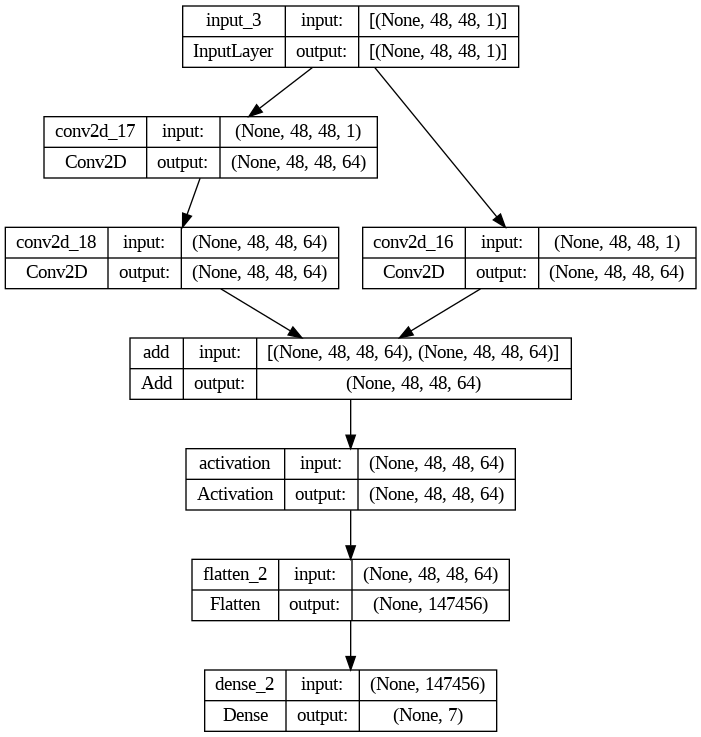

In [30]:
model_residual.summary()
plot_model(model_residual, show_shapes=True, to_file='residual_block.png')

In [31]:
history_residual = model_residual.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[time_callback_resid])

Epoch 1/20
752/752 [==============================] - 12s 14ms/step - loss: 121.6104 - accuracy: 0.2141 - val_loss: 1.8410 - val_accuracy: 0.2450
Epoch 2/20
752/752 [==============================] - 9s 12ms/step - loss: 1.7911 - accuracy: 0.2660 - val_loss: 1.8490 - val_accuracy: 0.2461
Epoch 3/20
752/752 [==============================] - 9s 12ms/step - loss: 1.7248 - accuracy: 0.2953 - val_loss: 1.9311 - val_accuracy: 0.2498
Epoch 4/20
752/752 [==============================] - 10s 13ms/step - loss: 1.6637 - accuracy: 0.3199 - val_loss: 2.0833 - val_accuracy: 0.2539
Epoch 5/20
752/752 [==============================] - 8s 11ms/step - loss: 1.6146 - accuracy: 0.3468 - val_loss: 2.1867 - val_accuracy: 0.2574
Epoch 6/20
752/752 [==============================] - 9s 12ms/step - loss: 1.5566 - accuracy: 0.3742 - val_loss: 2.3671 - val_accuracy: 0.2587
Epoch 7/20
752/752 [==============================] - 8s 11ms/step - loss: 1.5099 - accuracy: 0.3938 - val_loss: 2.5967 - val_accuracy: 0.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 48, 48, 64)           640       ['input_4[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 48, 48, 64)           36928     ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 64)           0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

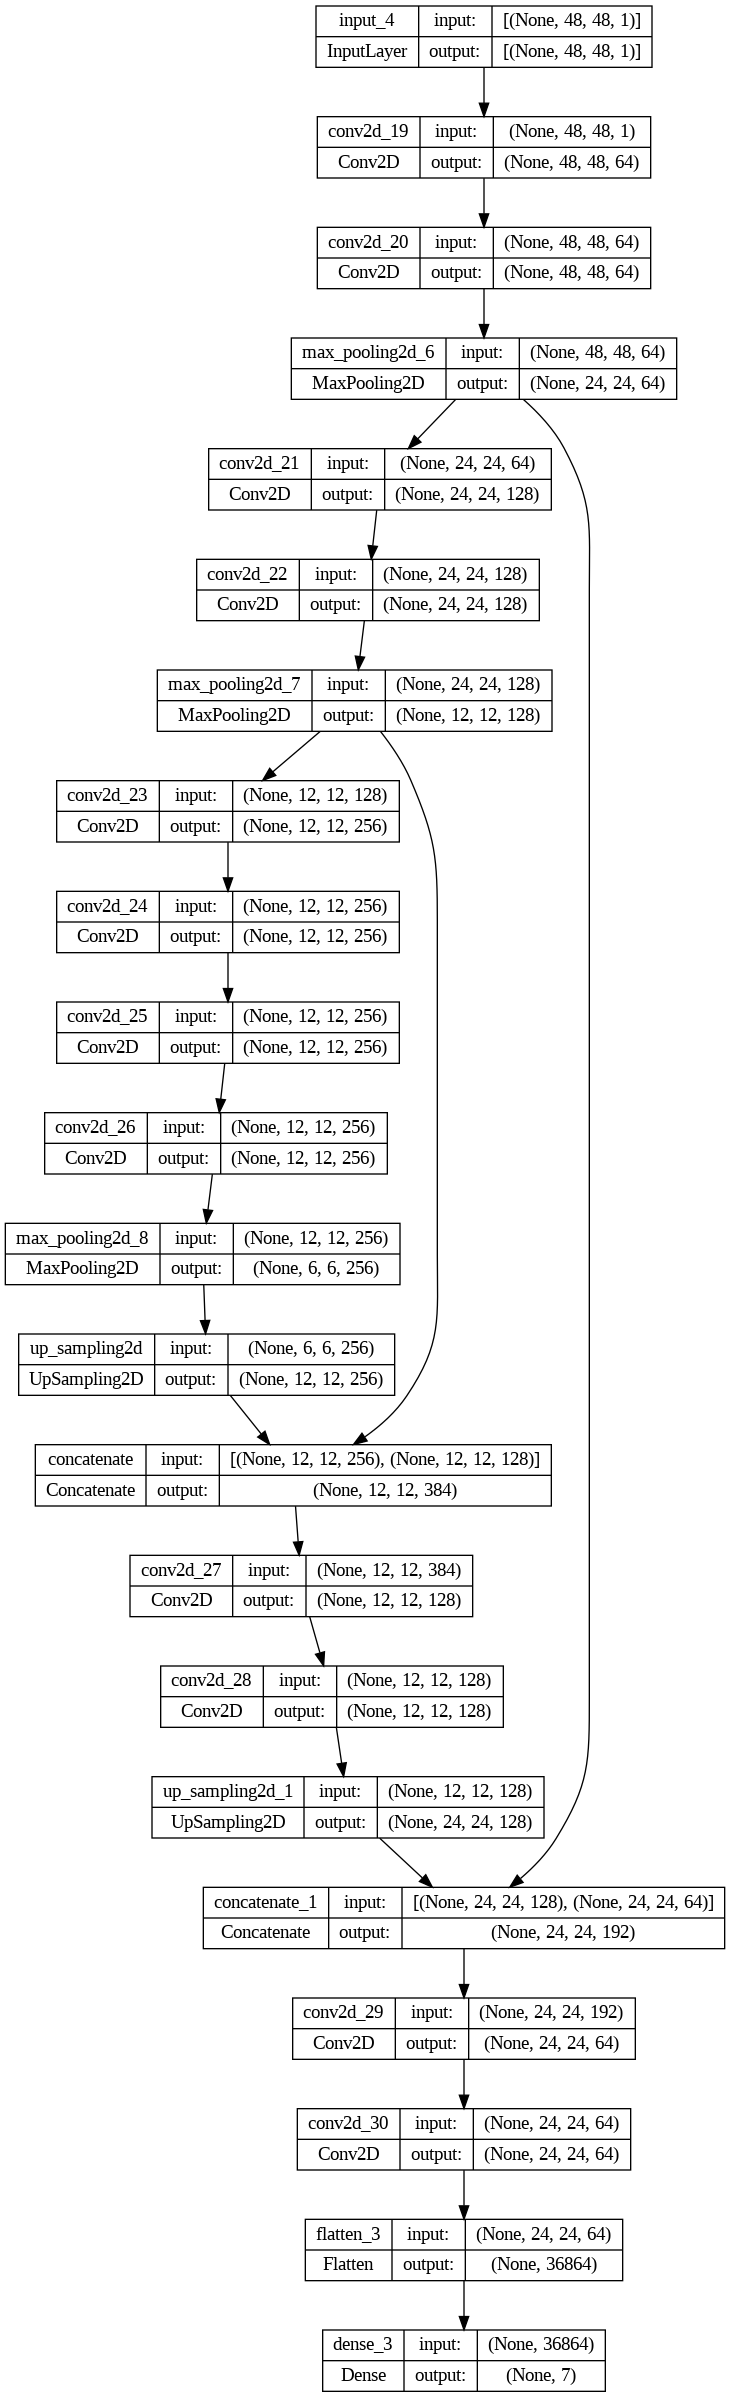

In [32]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, UpSampling2D

def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

def unet_block(layer_in, skip_in, n_filters):
    layer_in = UpSampling2D((2, 2))(layer_in)
    layer_in = concatenate([layer_in, skip_in], axis=-1)
    layer_in = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(layer_in)
    layer_in = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(layer_in)
    return layer_in


visible = Input(shape=(48, 48, 1))
vgg1 = vgg_block(visible, 64, 2)
vgg2 = vgg_block(vgg1, 128, 2)
vgg3 = vgg_block(vgg2, 256, 4)
unet1 = unet_block(vgg3, vgg2, 128)
unet2 = unet_block(unet1, vgg1, 64)
flat = Flatten()(unet2)
output = Dense(7, activation='softmax')(flat)



unet_model = Model(inputs=visible, outputs=output)
unet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
unet_model.summary()
plot_model(unet_model, show_shapes=True, to_file='vgg_unet.png')


In [33]:
unet_history = unet_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[time_callback_unet])

Epoch 1/20
752/752 [==============================] - 29s 31ms/step - loss: 1.9715 - accuracy: 0.2892 - val_loss: 1.7335 - val_accuracy: 0.3029
Epoch 2/20
752/752 [==============================] - 23s 30ms/step - loss: 1.5896 - accuracy: 0.3861 - val_loss: 1.5751 - val_accuracy: 0.3990
Epoch 3/20
752/752 [==============================] - 22s 30ms/step - loss: 1.4663 - accuracy: 0.4419 - val_loss: 1.4873 - val_accuracy: 0.4271
Epoch 4/20
752/752 [==============================] - 25s 33ms/step - loss: 1.3350 - accuracy: 0.4950 - val_loss: 1.4702 - val_accuracy: 0.4430
Epoch 5/20
752/752 [==============================] - 24s 33ms/step - loss: 1.1915 - accuracy: 0.5527 - val_loss: 1.4913 - val_accuracy: 0.4567
Epoch 6/20
752/752 [==============================] - 22s 30ms/step - loss: 1.0278 - accuracy: 0.6188 - val_loss: 1.6087 - val_accuracy: 0.4486
Epoch 7/20
752/752 [==============================] - 23s 30ms/step - loss: 0.8485 - accuracy: 0.6909 - val_loss: 1.7541 - val_accuracy:

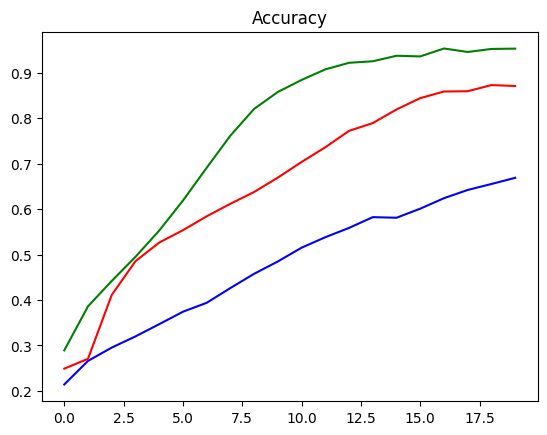

In [34]:
plt.title("Accuracy")
plt.plot(history_residual.history['accuracy'], 'b')
plt.plot(unet_history.history['accuracy'], 'g')
plt.plot(history_vgg.history['accuracy'], 'r')

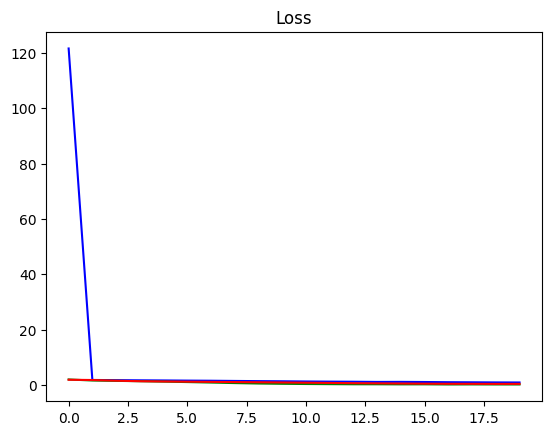

In [35]:
plt.title("Loss")
plt.plot(history_residual.history['loss'], 'b')
plt.plot(unet_history.history['loss'], 'g')
plt.plot(history_vgg.history['loss'], 'r')

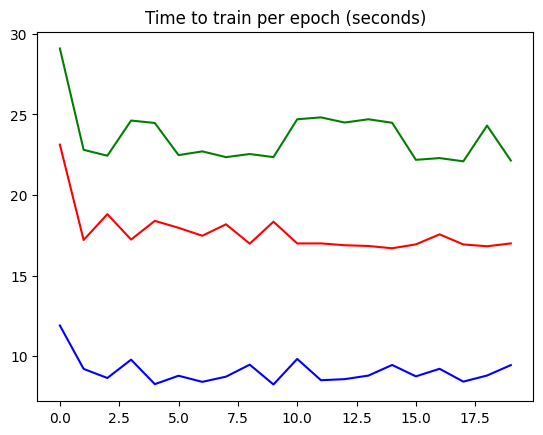

In [36]:
plt.title("Time to train per epoch (seconds)")
plt.plot(time_callback_resid.times, 'b')
plt.plot(time_callback_unet.times, 'g')
plt.plot(time_callback_vgg.times, 'r')

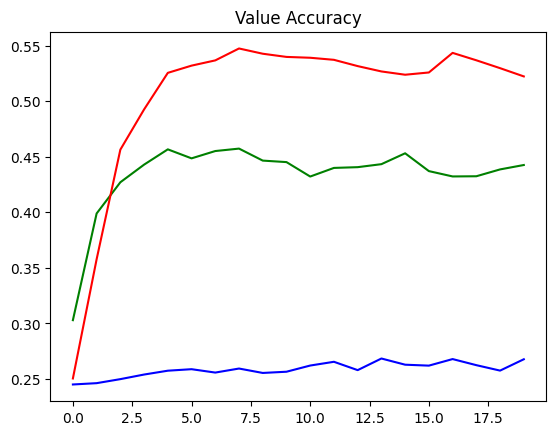

In [37]:
plt.title("Value Accuracy")
plt.plot(history_residual.history['val_accuracy'], 'b')
plt.plot(unet_history.history['val_accuracy'], 'g')
plt.plot(history_vgg.history['val_accuracy'], 'r')

In [40]:
vgg_pred = model_vgg.predict(x_test)
res_pred = model_residual.predict(x_test)
unet_pred = unet_model.predict(x_test)

371/371 [==============================] - 3s 8ms/step


In [46]:
from sklearn.metrics import classification_report, confusion_matrix


print(vgg_pred)
print(res_pred)
print(unet_pred)

vgg_pred_classes = np.argmax(vgg_pred, axis=1)
res_pred_classes = np.argmax(res_pred, axis=1)
unet_pred_classes = np.argmax(unet_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

vgg_report = classification_report(y_test_classes, vgg_pred_classes)
res_report = classification_report(y_test_classes, res_pred_classes)
unet_report = classification_report(y_test_classes, unet_pred_classes)

# 打印分类报告
print("VGG Classification Report:")
print(vgg_report)

print("\nResidual Classification Report:")
print(res_report)

print("\nUNet Classification Report:")
print(unet_report)

[[5.7232123e-02 4.5882197e-11 2.3180975e-04 ... 5.3280388e-04
  2.8625983e-01 4.3647620e-03]
 [1.8856964e-06 2.5523434e-22 1.5165554e-10 ... 9.1057424e-13
  8.3038310e-10 5.1447907e-05]
 [3.3231726e-07 2.8731480e-07 2.9564951e-02 ... 9.6431500e-01
  4.1616189e-05 6.0777641e-03]
 ...
 [1.3383068e-09 2.5857802e-18 9.8003532e-08 ... 2.1364365e-06
  4.7553899e-06 3.1361017e-02]
 [4.8435822e-02 1.0986341e-06 5.7705557e-01 ... 3.6633077e-01
  5.0225831e-04 4.9728076e-03]
 [2.2625027e-05 1.3570524e-06 1.7965118e-06 ... 1.7715240e-06
  2.0220117e-08 1.7723604e-08]]
[[1.08114012e-01 1.92509294e-02 1.79125413e-01 ... 1.79181054e-01
  9.44395587e-02 1.48973823e-01]
 [2.73518525e-02 3.00577516e-03 8.80947784e-02 ... 1.89491019e-01
  1.03180604e-02 3.80801618e-01]
 [1.11460313e-01 1.50814159e-02 1.14711724e-01 ... 1.59372002e-01
  1.48161948e-01 1.55368581e-01]
 ...
 [3.50911032e-05 4.86231555e-10 1.80656801e-03 ... 5.80589712e-01
  7.39427879e-02 9.76952947e-07]
 [1.99611649e-01 1.08863071e-06 8.1

In [48]:
unet_model.save("unet.h5")
model_residual.save("res.h5")
model_vgg.save("vgg.h5")